In [ ]:
# Date: 20.3.2023
# Author: Antti Kiviaho
#
# Notebook for analysing and visualizing visium data after copy number variation, single cell mapping and clustering
# analyses. This is the main results notebook

## Packages and data download

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

#from cell2location.utils import select_slide
#from cell2location.plt import plot_spatial

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids
import matplotlib as mpl

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
#c2l-results/cell2location_map_20230322/
adata_vis = sc.read_h5ad('./c2l-results/visium_adata_with_c2l_mapping_20230615.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])


adata_slides = load_from_pickle('./data/individual_sections_normalized_clustered.pickle')
samples = get_sample_ids()

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']


## Nuclei counting breakdown

In [37]:
# Looking at segmentation-based nuclei counts
nuclei_counts = load_from_pickle('visium_slide_nuclei_counts.pickle')
nuclei_counts['n_nuclei'] = nuclei_counts['n_nuclei'].astype(int)

meta = adata_vis.obs.copy()
meta = pd.merge(meta,nuclei_counts,left_index=True,right_index=True,how='left')
if (meta.index == adata_vis.obs.index).all():
    adata_vis.obs = meta
    print('merged!')

count    32664.000000
mean        21.199731
std         11.605211
min          1.000000
25%         12.000000
50%         21.000000
75%         29.000000
max        100.000000
Name: n_nuclei, dtype: float64

In [ ]:
# This code will create a 5 by 5 inches axis for each plot, 
# save them in plots/c2l_mapping_results_20230511/ with a 
# sample-specific filename, and set the dpi to 300.
cd3_genes = ['CD3D','CD3E','CD247']
#samples = [s for s in samples if 'CRPC' in s]
import os
for sample in samples:
    slide = adata_slides[sample].copy()
    slide.obs['CD3_sum'] = np.sum(slide[:,cd3_genes].layers['counts'].todense(),axis=1).flatten().tolist()[0]

    # import matplotlib library
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages

    # set figure axis size and dpi
    fig, ax = plt.subplots(figsize=(3, 3), dpi=100)

    # create spatial plot
    sc.pl.spatial(slide, cmap='viridis',
            # show first 8 cell types
            color='CD3_sum',size=1.3,alpha_img=0.8,
            vmin=0, vmax=6, ax=ax, show=False, title=sample)

    # create filename with sample name
    filename = 'plots/c2l_mapping_results_20230511/cd3_expression/' + sample + '_spatial_cd3_sum_plot.pdf'

    # create output folder if it doesn't exist
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))

    # save plot to pdf with filename
    with PdfPages(filename) as pdf:
        pdf.savefig(fig)




## Visium mapping plots

In [ ]:
# Plots and saves top n_types with highest prevelance on visium slides
n_types = 12

for sample in samples:
    slide = adata_slides[sample]
    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types]

    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                        'figure.figsize': [4.5, 5]}):

        sc.pl.spatial(slide, cmap='magma',
                    # show first 8 cell types
                    color=cell_types.index,
                    ncols=4, size=1.3,alpha_img=0.8,
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax='p99.2', show=False
                    )
        plt.savefig('./plots/c2l_mapping_results_20230608/'+sample+'_c2l_mapping_top12_abundant.png',dpi=200)
        plt.clf()

In [ ]:
## Side by side violin plots of abundant cell types + spatial 

plt.rcParams.update({'axes.titlesize': 'small'})

n_types = 6
obs_name = 'joint_leiden_clusters'

for s in samples:

    slide = adata_slides[s]

    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types].index

    fig = plt.figure(figsize=(12,12))

    gs = fig.add_gridspec(6,3)
    ax6 = fig.add_subplot(gs[:, 1:3])

    # Plot the data in the left column subplots
    for i in range(6):

        ax_plotting = fig.add_subplot(gs[i,0])

        sc.pl.violin(slide,groupby=obs_name,keys=cell_types[i],jitter=False,rotation=45,inner='box',
                    ax=ax_plotting,show=False)
        
        ax_plotting.yaxis.label.set_size(12)
        #ax_plotting.yaxis.label.set_rotation('horizontal')

        if i < 5:  # only remove x-labels for the top 5 subplots on the left
            ax_plotting.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 

    sc.pl.spatial(adata_slides[s],color='joint_leiden_clusters',size=1.3,ax=ax6)

    fig.savefig('./plots/c2l_mapping_results_20230608/'+s+'_cell_type_prevalences_per_cluster.png')
    fig.clf()



In [ ]:
cell_types = ['luminal-like epithelium', 'ERG tumor epithelium', 'inflammatory fibroblasts','myofibroblasts']
cell_types2 = ['basal-like epithelium', 'prostaglandind active epithelium','antigen presenting fibroblasts','pericytes']

for sample in samples:
    slide = adata_slides[sample]
    fig, axs = plt.subplots(2, 4, sharey='row')
    for i, cell_type in enumerate(cell_types):
        axs[0, i].set_ylim([0, 20])
        sc.pl.violin(slide, groupby='joint_leiden_clusters', keys=cell_type, jitter=False,
            rotation=45, inner='box', show=False, ax=axs[0, i])
    for i, cell_type in enumerate(cell_types2):
        axs[1, i].set_ylim([0, 10])
        sc.pl.violin(slide, groupby='joint_leiden_clusters', keys=cell_type, jitter=False,
            rotation=45, inner='box', show=False, ax=axs[1, i])
    plt.gcf().set_size_inches(16, 8)
    plt.savefig(os.path.join('plots/c2l_mapping_results_20230608', f'{sample}_8_celltypes_violinplots.pdf'))
    plt.clf()


## Secondary analysis of the cell type mapping numbers

In [48]:
# Creating an anndata-structure for inferred cell numbers

# Filters if necessary
ctypes = adata_vis.uns['mod']['factor_names']
#ctypes = [ctype for ctype in ctypes if 'epithelial' in ctype or 'fibroblast' in ctype]

cell_mapping_dat = sc.AnnData(adata_vis.obs[ctypes])
if (cell_mapping_dat.obs.index == adata_vis.obs.index).all():
    cell_mapping_dat.obs = adata_vis.obs[['sample_id','joint_leiden_clusters']]


if (adata_vis.obs.index == cell_mapping_dat.obs.index).all():
    adata_vis.obs['inferred_cell_counts'] = np.round(np.sum(cell_mapping_dat.X,axis=1),0).tolist()
    print('Inferred cell counts copied!')

cell_mapping_dat


Inferred cell counts copied!


AnnData object with n_obs × n_vars = 32664 × 47
    obs: 'sample_id', 'joint_leiden_clusters'

In [54]:
sc.pp.pca(cell_mapping_dat)
sc.pp.neighbors(cell_mapping_dat)
sc.tl.umap(cell_mapping_dat)
sc.tl.leiden(cell_mapping_dat,key_added='mapping_based_clusters', resolution=0.5)

In [56]:
cell_mapping_dat

AnnData object with n_obs × n_vars = 32664 × 47
    obs: 'sample_id', 'joint_leiden_clusters', 'mapping_based_clusters'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [60]:
subset

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,resident memory T cells,ribosome CRPC fibroblasts,stress response fibroblasts,stress response hypoxic myeloids,stress response myeloids,stressed capillary venous endothelium,stressed capillary venous enodthelium,stressed infammatory fibroblasts,suppressory monocytes,viral reaction macrophages
BPH_651_AAACAGCTTTCAGAAG-1,1,43,9,1418,7.257708,2384.0,7.776954,24.370805,33.431208,44.127517,...,0.036245,0.178368,0.026831,0.007531,0.008056,0.009367,0.025005,0.016668,0.004100,0.005599
BPH_651_AAACAGGGTCTATATT-1,1,47,13,1851,7.524021,3331.0,8.111328,21.645152,30.681477,41.519063,...,0.302345,0.041174,0.054174,0.017815,0.017200,0.005330,0.015219,0.013567,0.023561,0.121468
BPH_651_AAACATTTCCCGGATT-1,1,61,97,2338,7.757479,4896.0,8.496378,22.058824,31.964869,42.299837,...,0.268231,0.671973,0.124520,0.011710,0.033241,0.044152,0.093739,0.021428,0.144115,0.042427
BPH_651_AAACCGGGTAGGTACC-1,1,42,28,2186,7.690286,4391.0,8.387540,22.455022,31.906172,42.928718,...,0.160304,0.075754,0.016829,0.021749,0.027958,0.012756,0.016971,0.021410,0.017514,0.019592
BPH_651_AAACCGTTCGTCCAGG-1,1,52,42,3253,8.087640,8271.0,9.020632,23.431266,34.880909,45.327046,...,0.721050,0.794335,0.146254,0.011798,0.034473,0.031223,0.082038,0.007126,0.128448,0.187913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BPH_651_TTGTTAGCAAATTCGA-1,1,22,42,609,6.413459,859.0,6.756932,28.288708,39.930151,52.386496,...,0.200409,0.040548,0.012916,0.004022,0.007158,0.002905,0.009964,0.005250,0.013969,0.061671
BPH_651_TTGTTCAGTGTGCTAC-1,1,24,64,1507,7.318540,2983.0,8.001020,29.902782,38.786457,49.379819,...,0.072116,0.440317,0.067757,0.010497,0.016828,0.013375,0.028813,0.029034,0.014438,0.011905
BPH_651_TTGTTGTGTGTCAAGA-1,1,31,77,2795,7.935945,5747.0,8.656608,20.201844,29.441448,39.585871,...,0.570097,0.116590,0.045031,0.009862,0.022480,0.016149,0.034820,0.011051,0.066372,0.113581
BPH_651_TTGTTTCACATCCAGG-1,1,58,42,3227,8.079618,6959.0,8.847935,20.721368,29.558845,39.014226,...,0.181490,0.022117,0.011175,0.017595,0.011548,0.006659,0.011514,0.011494,0.016366,0.033987


In [67]:
cell_mapping_dat.obs[adata_slides[s].obs_names]#['mapping_based_clusters']

KeyError: "None of [Index(['BPH_651_AAACAGCTTTCAGAAG-1', 'BPH_651_AAACAGGGTCTATATT-1',\n       'BPH_651_AAACATTTCCCGGATT-1', 'BPH_651_AAACCGGGTAGGTACC-1',\n       'BPH_651_AAACCGTTCGTCCAGG-1', 'BPH_651_AAACCTAAGCAGCCGG-1',\n       'BPH_651_AAACCTCATGAAGTTG-1', 'BPH_651_AAACGAGACGGTTGAT-1',\n       'BPH_651_AAACGGGCGTACGGGT-1', 'BPH_651_AAACTCGGTTCGCAAT-1',\n       ...\n       'BPH_651_TTGTGCAGCCACGTCA-1', 'BPH_651_TTGTGGTAGGAGGGAT-1',\n       'BPH_651_TTGTGGTGGTACTAAG-1', 'BPH_651_TTGTGTATGCCACCAA-1',\n       'BPH_651_TTGTGTTTCCCGAAAG-1', 'BPH_651_TTGTTAGCAAATTCGA-1',\n       'BPH_651_TTGTTCAGTGTGCTAC-1', 'BPH_651_TTGTTGTGTGTCAAGA-1',\n       'BPH_651_TTGTTTCACATCCAGG-1', 'BPH_651_TTGTTTCCATACAACT-1'],\n      dtype='object', length=2020)] are in the [columns]"

In [63]:
#for s in samples:
adata_slides[s].obs['mapping_based_clusters'] = cell_mapping_dat.obs[adata_slides[s].obs_names]['mapping_based_clusters'].copy()

KeyError: "None of [Index(['BPH_651_AAACAGCTTTCAGAAG-1', 'BPH_651_AAACAGGGTCTATATT-1',\n       'BPH_651_AAACATTTCCCGGATT-1', 'BPH_651_AAACCGGGTAGGTACC-1',\n       'BPH_651_AAACCGTTCGTCCAGG-1', 'BPH_651_AAACCTAAGCAGCCGG-1',\n       'BPH_651_AAACCTCATGAAGTTG-1', 'BPH_651_AAACGAGACGGTTGAT-1',\n       'BPH_651_AAACGGGCGTACGGGT-1', 'BPH_651_AAACTCGGTTCGCAAT-1',\n       ...\n       'BPH_651_TTGTGCAGCCACGTCA-1', 'BPH_651_TTGTGGTAGGAGGGAT-1',\n       'BPH_651_TTGTGGTGGTACTAAG-1', 'BPH_651_TTGTGTATGCCACCAA-1',\n       'BPH_651_TTGTGTTTCCCGAAAG-1', 'BPH_651_TTGTTAGCAAATTCGA-1',\n       'BPH_651_TTGTTCAGTGTGCTAC-1', 'BPH_651_TTGTTGTGTGTCAAGA-1',\n       'BPH_651_TTGTTTCACATCCAGG-1', 'BPH_651_TTGTTTCCATACAACT-1'],\n      dtype='object', length=2020)] are in the [columns]"

In [34]:
sq.gr.spatial_neighbors(cell_mapping_dat)
sq.gr.nhood_enrichment(cell_mapping_dat, cluster_key="mapping_based_clusters")
sq.pl.nhood_enrichment(cell_mapping_dat, cluster_key="mapping_based_clusters")

KeyError: 'Spatial basis `spatial` not found in `adata.obsm`.'

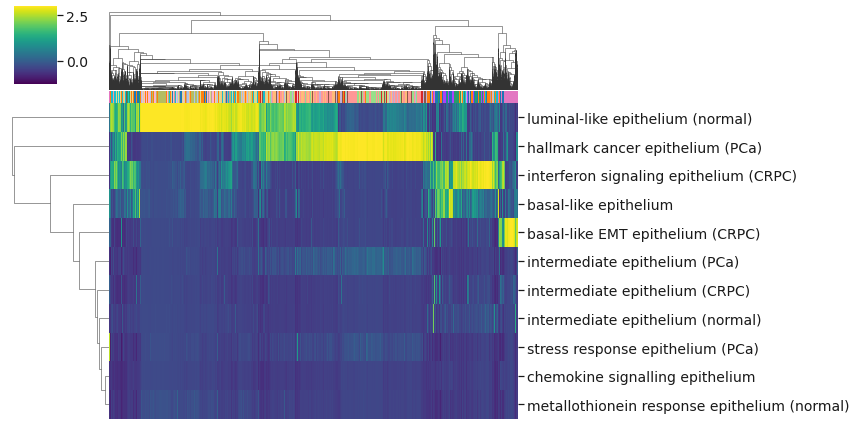

In [10]:
# Plotting the cluster-averaged cell counts into a heatmap for easier interpretation
ctype_start = 0
n_ctypes = 15
n_cells_col_cap = 3

# Take 10 most prevalent cell types and use them for the heatmap
#heatmap_vars = np.array(cell_mapping_dat.var_names[np.argsort(np.sum(
#    cell_mapping_dat.X,axis=0))[::-1]])[ctype_start:ctype_start + n_ctypes]

# Backup for taking specific cell types
heatmap_vars = [x for x in scaled_cell_mapping_dat.var_names if "epithelium" in x] # Fibroblasts etc.


# Convert X and annotations to pandas DataFrame
df = pd.DataFrame(cell_mapping_dat.X)
df.columns = cell_mapping_dat.var_names
df = df[heatmap_vars]

# Extract sample names from index values
sample_names = adata_vis.obs['sample_id']

# Create a dictionary that maps each sample name to a color
color_map = {sample: sns.color_palette()[i] for i, sample in enumerate(sorted(set(sample_names)))}

# Use the color_map dictionary to assign colors to each index value
colors = [color_map[sample_name] for sample_name in sample_names]

sns.clustermap(df.T, col_colors=colors, cmap='magma', z_score=1,
                vmax=n_cells_col_cap, figsize=(12,6), xticklabels=False)


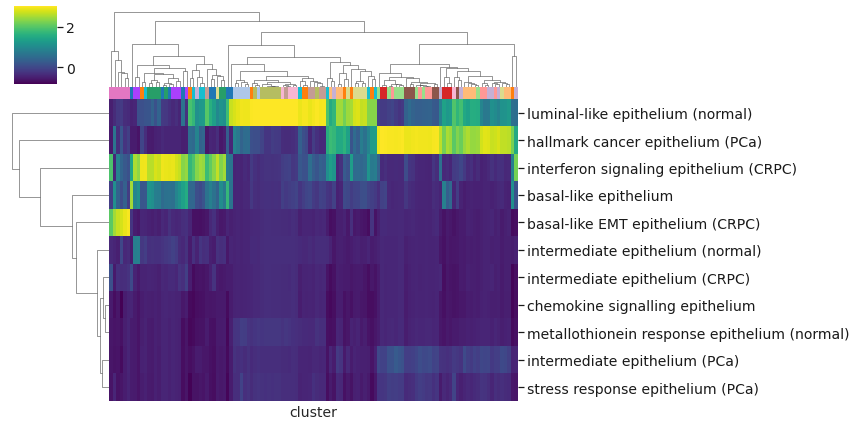

In [9]:
# Plotting the cluster-averaged cell counts into a heatmap for easier interpretation
ctype_start = 0
n_ctypes = 15
n_cells_col_cap = 3

# Take 10 most prevalent cell types and use them for the heatmap
#heatmap_vars = np.array(cell_mapping_dat.var_names[np.argsort(np.sum(
#    cell_mapping_dat.X,axis=0))[::-1]])[ctype_start:ctype_start + n_ctypes]

# Backup for taking specific cell types
heatmap_vars = [x for x in scaled_cell_mapping_dat.var_names if "epithelium" in x]


# Convert X and annotations to pandas DataFrame
df = pd.DataFrame(cell_mapping_dat.X)
df['cluster'] = cell_mapping_dat.obs['joint_leiden_clusters'].tolist()
#df['sample_id'] = cell_mapping_dat.obs['sample_id']

# Group rows by their annotation values and calculate the average of each group
averaged_df = df.groupby('cluster').mean()
averaged_df.columns = cell_mapping_dat.var_names

averaged_df = averaged_df[heatmap_vars]

# Extract sample names from index values
sample_names = ['_'.join(index.split("_")[:-1]) for index in averaged_df.index]

# Create a dictionary that maps each sample name to a color
color_map = {sample: sns.color_palette()[i] for i, sample in enumerate(sorted(set(sample_names)))}

# Use the color_map dictionary to assign colors to each index value
colors = [color_map[sample_name] for sample_name in sample_names]

sns.clustermap(averaged_df.T, col_colors=colors, cmap='viridis', z_score=1,
                vmax=n_cells_col_cap, figsize=(12,6), xticklabels=False)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create an empty plot
fig, ax = plt.subplots()

# Create a list of labels and colors
legend_labels = list(color_map.keys())
legend_colors = list(color_map.values())

# Convert the float tuples to valid RGB color strings
colors = ['#%02x%02x%02x' % tuple(int(255*x) for x in color) for color in legend_colors]

# Create color patches for each label
patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

# Add the legend to the plot
ax.legend(handles=patches, prop={"size": 10}, loc='best', framealpha=1, edgecolor='black', facecolor='white',
          title='Legend Title', labelcolor='black', fancybox=True, shadow=True,  bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()


## Spatial Leiden cluster merging 

In [ ]:
from sklearn.metrics import silhouette_score, pairwise_distances

# Define functions

## Calclulates the euclidean distance on cluster level yield to information about which clusters are closest to each other
def calculate_distances(cluster_means_df,n_closest=5):
    closest_names = np.empty((0,n_closest))
    closest_dist = np.empty((0,n_closest))

    for idx in range (len(cluster_means_df)):

        # Divide the df into the query (1 cluster) and the rest
        comparison_dat = cluster_means_df.iloc[idx]
        rest_of_the_dat = cluster_means_df.drop(index=[cluster_means_df.index[idx]])

        # Repeat one row to match the shape of the rest
        comparison_dat_reshaped = np.tile(comparison_dat,(rest_of_the_dat.shape[0],1))
        res = np.linalg.norm(rest_of_the_dat-comparison_dat_reshaped,axis=1)
        matches = np.asarray(list(rest_of_the_dat.index[np.argsort(res)[:n_closest]]))

        # Stack names and distances of closest matches
        closest_names = np.vstack([closest_names,matches])
        closest_dist = np.vstack([closest_dist,np.sort(res)[:n_closest]])

    # Convert to dataframes for easy slicing
    closest_names = pd.DataFrame(closest_names,index=cluster_means_df.index)
    closest_dist = pd.DataFrame(closest_dist,index=cluster_means_df.index)
    return(closest_names,closest_dist)

# Compare sample names of the index and the first column to find if the nearest cluster is from another sample. Only keep those
def find_nearest_neighbors(df):
    slices = []
    for idx in range(len(df)):
        if (('_').join(df.index[idx].split('_')[:-1]) != 
        ('_').join(df[0][idx].split('_')[:-1])):
            slices.append(idx)

    # These are the spatial clusters with different sample nearest cluster
    return(df.iloc[slices])

# Keep clusters that are mutual nearest neighbors (MNN)
def find_mnn_clusters(df):
    slices = []
    for idx in range(len(df)):
        if (df[0][idx] in df.index):
            if df.loc[df[0][idx]][0] == df.index[idx]:
                if df[0][idx] not in df.iloc[slices].index:
                    slices.append(idx)

    # These are the spatial clusters with mutual nearest neighbors
    return(df.iloc[slices])

def sample_is_duplicated(to_check,lst):
    found = False
    for element in lst:
        if to_check[:-2] in element:
            found = True
            break

    return found


    

In [ ]:
data_to_use = cell_mapping_dat

# Extracts spot level mapping values and averages to cluster level for mutual nearest neighbor comparison
spot_lvl_data = pd.DataFrame(data_to_use.X,index=data_to_use.obs_names)
spot_lvl_data['spatial_cluster'] = data_to_use.obs['joint_leiden_clusters'].copy()
spot_lvl_labs = data_to_use.obs['joint_leiden_clusters'].copy()

# Speed up the analysis by precomputing a distance matrix
#distance_array = pairwise_distances(cell_mapping_dat.X)
#ref_score = silhouette_score(distance_array,spot_lvl_labs,metric='precomputed')
ref_score = -1 # If the reference score is set to -1, we effectively lose the silhouette score if-clause

# A mapping-based clustering silhouette score is -0.23051132


In [ ]:
def is_score_ok(new_labs,df=distance_array, reference = ref_score):
    '''
    Checks the silhouette score of new clustering labels and compares them to a reference of 
    the original clustering
    '''
    new_score = silhouette_score(df,new_labs,metric='precomputed')
    if new_score > reference:
        return(True)
    else:
        return(False)

In [ ]:
# Take the cluster back to the original, unmerged leiden clusters
spot_lvl_data['merged_clusters'] = spot_lvl_data['spatial_cluster']
cluster_idx = 1
modified_clusters = dict()
len(spot_lvl_data['merged_clusters'].unique())

In [ ]:
## Iterate below code ###

In [ ]:
spot_lvl_labs = spot_lvl_data['merged_clusters'].copy()

# Calculate cluster means in the cell mapping space
cluster_lvl_dat = spot_lvl_data.groupby('merged_clusters').mean()

# Calculate euclidean distance between the clusters
names, dist = calculate_distances(cluster_lvl_dat)

# Find MNN clusters that are from different samples
filtered_names = find_nearest_neighbors(names)
cluster_pairs = find_mnn_clusters(filtered_names)
cluster_pairs

In [ ]:
# Find mergeable clusters by checking different conditions
# Iterate over the clusters
for idx in range(len(cluster_pairs)):
    inst_1 = str(cluster_pairs.index[idx])
    inst_2 = str(cluster_pairs.iloc[idx][0])
    message = (inst_1 + ' <--> ' + inst_2 + ' merged')

    # Check if the index is already a merged cluster
    if inst_1 in modified_clusters.keys():

        ## This needs to fixed to check whether the dict member contains same sample clusters already!!

        if not sample_is_duplicated(inst_2,modified_clusters[inst_1]):# & is_score_ok(spot_lvl_labs.replace(replaced,'test_cluster')):
            print(message)
            modified_clusters[inst_1].append(inst_2)
            print('option1')

    # Check if the index is already a merged cluster
    elif inst_2 in modified_clusters.keys():
        ## This needs to fixed to check whether the dict member contains same sample clusters already!!
        if not sample_is_duplicated(inst_1,modified_clusters[inst_2]):# & is_score_ok(spot_lvl_labs.replace(replaced,'test_cluster')):
            print(message)
            modified_clusters[inst_2].append(inst_1)
            print('option2')
    
    # If neither is a modified cluster, create a new cluster and save it
    if inst_2 not in modified_clusters.keys() and inst_1 not in modified_clusters.keys():
        print(message)
        modified_clusters['joint_cluster'+str(cluster_idx)] = [inst_1,inst_2]
        cluster_idx+=1
        print('option3')

for k in modified_clusters.keys():
    spot_lvl_data['merged_clusters'] = spot_lvl_data['merged_clusters'].replace(modified_clusters[k],k)


In [ ]:
len(spot_lvl_data['merged_clusters'].unique())

In [ ]:
modified_clusters

In [ ]:
## Stop iteration ##

In [ ]:
cell_mapping_dat.obs['merged_clusters'] = spot_lvl_data['merged_clusters'].copy()

In [ ]:
silhouette_score(cell_mapping_dat.X,spot_lvl_labs)

In [ ]:
sc.set_figure_params(figsize=(4,4),dpi=120)
cell_mapping_dat.obs['to_plot'] = np.nan
for n in np.arange(1,14):
    of_interest = 'joint_cluster'+str(n)

    cell_mapping_dat.obs.loc[(cell_mapping_dat.obs['merged_clusters']== of_interest),'to_plot'] = of_interest
sc.pl.umap(cell_mapping_dat,color='to_plot')

In [ ]:
[c.index for c in cell_mapping_dat.obs['merged_clusters'] if 'joint_cluster' in c]

In [ ]:
sc.pl.violin(cell_mapping_dat,groupby=['merged_clusters'],keys=['ERG tumor epithelium'],jitter=False,inner='box')

## Cell type mapping-based clustering and co-occurance

In [ ]:
# A way to investigate which cell types are over-represented in joint leiden clusters
# Does one-vs-rest differential expression (mapping) testing 

sc.tl.rank_genes_groups(cell_mapping_dat,groupby='joint_leiden_clusters')
for cl in cell_mapping_dat.obs['joint_leiden_clusters'].cat.categories:
    df = sc.get.rank_genes_groups_df(cell_mapping_dat,group=cl)
    df = df.iloc[np.where(df['logfoldchanges'] > np.quantile(df['logfoldchanges'],0.95))[0]]['names']
    print('Cluster ' + cl  + ' is characterized by these cell types:')
    print(df)
    print('')

In [ ]:
sc.set_figure_params(figsize=(6,6))
sc.pl.umap(cell_mapping_dat,color=['sample_id'],s = 8)
sc.pl.umap(cell_mapping_dat,color=['mapping_based_clusters'],s = 6)

In [ ]:
sc.set_figure_params(figsize=(4,4),dpi=100,frameon=True,format='pdf')
sc.pl.umap(cell_mapping_dat,color=['luminal-like epithelium','ERG tumor epithelium'], cmap='viridis',s=6,vmax=20)
sc.pl.umap(cell_mapping_dat,color=['inflammatory fibroblasts','myofibroblasts','basal-like epithelium'], cmap='viridis',s=6,vmax=10)
sc.pl.umap(cell_mapping_dat,color=['cytotoxic T cells','antigen-presenting macrophages','regulatory T cells'], cmap='viridis',s=6,vmax=5)

In [ ]:
n_cats = len(cell_mapping_dat.obs['mapping_based_clusters'].cat.categories)
final_nhood_enrichment_matrix = np.zeros([n_cats,n_cats])
for sample in samples:
    #Assign the sample from a list and make it the current "slide"
    slide = adata_slides[sample]

    #Check if "mapping_based_clusters" exists in "slide.obs", merge with "cell_mapping_dat.obs" if yes
    if 'mapping_based_clusters' not in slide.obs.columns:
        obs_with_mapping_clusters = pd.merge(slide.obs,cell_mapping_dat.obs[['mapping_based_clusters']],left_index=True,right_index=True)
        if (obs_with_mapping_clusters.index == slide.obs.index).all():
            slide.obs = obs_with_mapping_clusters
            
    #Create the spatial neighborhood graph for the cells in "slide"
    sq.gr.spatial_neighbors(slide)

    #Calculate the enrichment of each cluster defined in "mapping_based_clusters" within its neighboring cells
    sq.gr.nhood_enrichment(slide, cluster_key="mapping_based_clusters")

    slide_nhood_enrichment_matrix = slide.uns['mapping_based_clusters_nhood_enrichment']['zscore'].copy()
    slide_nhood_enrichment_matrix = np.nan_to_num(slide_nhood_enrichment_matrix)
    final_nhood_enrichment_matrix = final_nhood_enrichment_matrix + slide_nhood_enrichment_matrix

#Visualize the results of the neighborhood enrichment analysis
#sq.pl.nhood_enrichment(slide, cluster_key="mapping_based_clusters",title=sample + ' mapping-based cluster neighborhood enrichment')
sns.heatmap(final_nhood_enrichment_matrix, cmap='viridis',vmax = 100 ) # annot=True, fmt=".1f"


In [ ]:
for sample in samples:
    #Assign the sample from a list and make it the current "slide"
    slide = adata_slides[sample]

    #Check if "mapping_based_clusters" exists in "slide.obs", merge with "cell_mapping_dat.obs" if yes
    if 'mapping_based_clusters' not in slide.obs.columns:
        obs_with_mapping_clusters = pd.merge(slide.obs,cell_mapping_dat.obs[['mapping_based_clusters']],left_index=True,right_index=True)
        if (obs_with_mapping_clusters.index == slide.obs.index).all():
            slide.obs = obs_with_mapping_clusters
    
    with mpl.rc_context({'axes.facecolor':  'white',
                    'figure.figsize': [6,6]}):
        fig, ax = plt.subplots(1,1)
        sc.pl.spatial(slide,
                color='mapping_based_clusters',
                size=1.4,alpha_img=0.8,
                show=False,ax = ax
                )
        plt.savefig('./plots/c2l_mapping_results_20230519/'+sample+'_cell_type_mapping_based_clusters.png',dpi=120)
        plt.tight_layout()
        plt.clf()